In [ ]:
import sys
import os
sys.path.append("../")

In [41]:

import warnings
warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from IPython.display import clear_output
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import numpy as np

from oodeel.eval.metrics import bench_metrics
from oodeel.eval.plots import plot_ood_scores, plot_roc_curve, plot_2D_features
from oodeel.datasets import OODDataset
from oodeel.utils.torch_training_tools import train_torch_model
from methods import Dknn, Vim, energy, entropy, mahalanobis, Mls, Odin, Gram
from data_preprocessing import get_test_dataset_cifar10, get_test_dataset_svhn, get_train_dataset_cifar10
from models import load_pretrained_weights_32


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
# initilize data loaders
ds_train = get_train_dataset_cifar10()
ds_in = get_test_dataset_cifar10()
ds_out = get_test_dataset_svhn()


the length of the CIFAR-10 Training dataset :  50000
the length of the CIFAR-10 Test dataset :  10000
the length of the SVHN Test dataset :  26032


In [25]:
# initilize the pretrained model
model = load_pretrained_weights_32(dataset='CIFAR-10', model_version='s0')
model.to(device)
print(model)

checkpoint_path :  ../../models/CIFAR-10/cifar10_resnet18_32x32_base_e100_lr0.1_default/s0/best.ckpt
Model pretrained weight have been successfully loaded !
ResNet18_32(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

Test accuracy:	0.909800

=== Penultimate features viz ===


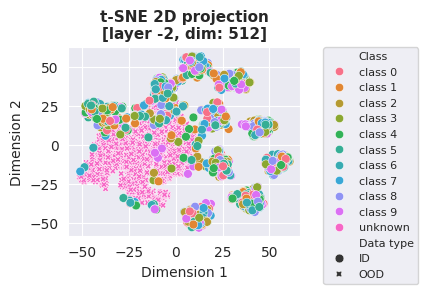

In [26]:
# evaluating thee model on test data to see test accuracy
model.eval()
labels, preds = [], []
for x, y in ds_in:
    x = x.to(device)
    preds.append(torch.argmax(model(x), dim=-1).detach().cpu())
    labels.append(y)
print(f"Test accuracy:\t{accuracy_score(torch.cat(labels), torch.cat(preds)):.6f}")

# penultimate features 2d visualization
print("\n=== Penultimate features viz ===")
plt.figure(figsize=(4.5, 3))
plot_2D_features(
    model=model,
    in_dataset=ds_in,
    out_dataset=ds_out,
    output_layer_id=-2,
)
plt.tight_layout()
plt.show()

# GRAM Method

In [36]:
model.to("cpu")
Gram.fit(model, ds_train, feature_layers_id=["fc"])
scores_in, _ = Gram.score(ds_in)
scores_out, _ = Gram.score(ds_out)


# Since many scores are equal to 0, we add a random noise to avoid bugs
# in Auroc and TPR computation.
scores_in += np.random.random_sample(size=scores_in.shape) * 10e-6
scores_out += np.random.random_sample(size=scores_out.shape) * 10e-6

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")


print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=True)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()


KeyboardInterrupt: 

# MLS Method

=== Metrics ===
auroc      0.872002
fpr95tpr   0.293800

=== Plots ===


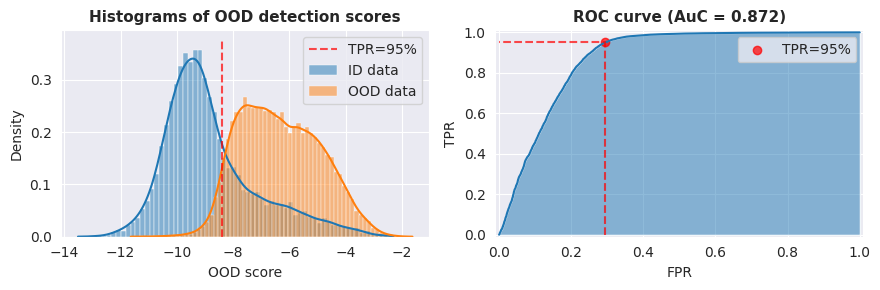

In [38]:
# === mls scores ===
Mls.fit(model)
scores_in, _ = Mls.score(ds_in)
scores_out, _ = Mls.score(ds_out)

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=False)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()

# ODIN Method

=== Metrics ===
auroc      0.756420
fpr95tpr   0.687400

=== Plots ===


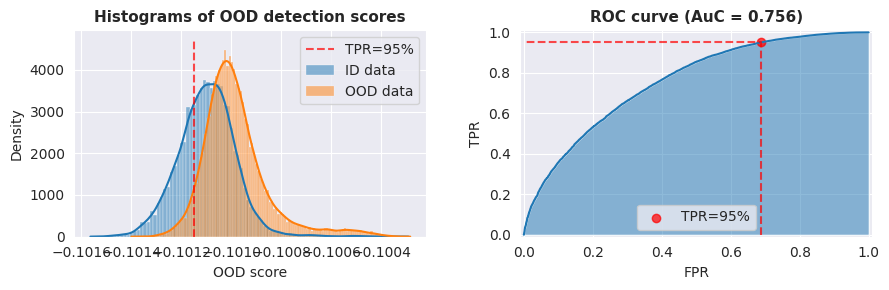

In [37]:
# === odin scores ===

Odin.fit(model)
scores_in, _ = Odin.score(ds_in)
scores_out, _ = Odin.score(ds_out)

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=False)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()

# DKNN Method

=== Metrics ===
auroc      0.845061
fpr95tpr   0.349300

=== Plots ===


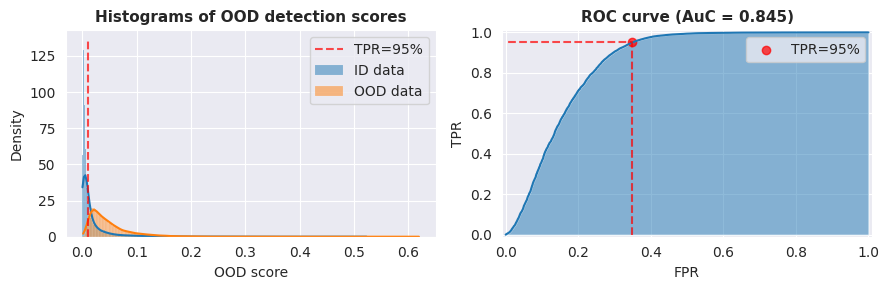

In [40]:
# === dknn scores ===
Dknn.fit(model, feature_layers_id=[-1], fit_dataset=ds_train)
scores_in, _ = Dknn.score(ds_in)
scores_out, _ = Dknn.score(ds_out)

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=False)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()

# VIM Method

=== Metrics ===
auroc      0.854891
fpr95tpr   0.312600

=== Plots ===


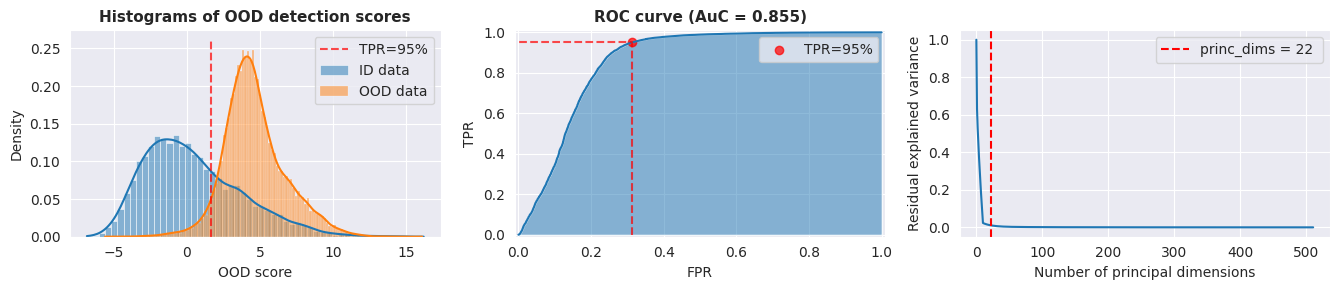

In [44]:
# === vim scores ===
Vim.fit(model, feature_layers_id=[-2], fit_dataset=ds_train)
scores_in, _ = Vim.score(ds_in)
scores_out, _ = Vim.score(ds_out)

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(13.5, 3))
plt.subplot(131)
plot_ood_scores(scores_in, scores_out, log_scale=False)
plt.subplot(132)
plot_roc_curve(scores_in, scores_out)
plt.subplot(133)
Vim.plot_spectrum()
plt.tight_layout()
plt.show()

# Energy Method

=== Metrics ===
auroc      0.873485
fpr95tpr   0.293800

=== Plots ===


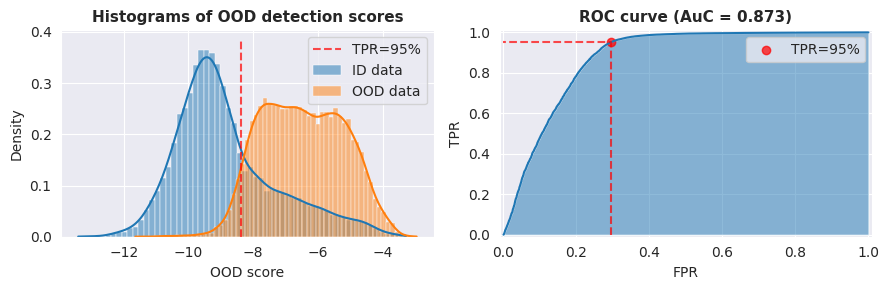

In [45]:
# === energy scores ===
energy.fit(model)
scores_in, _ = energy.score(ds_in)
scores_out, _ = energy.score(ds_out)

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=False)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()

# Entropy Method

=== Metrics ===
auroc      0.841893
fpr95tpr   0.313900

=== Plots ===


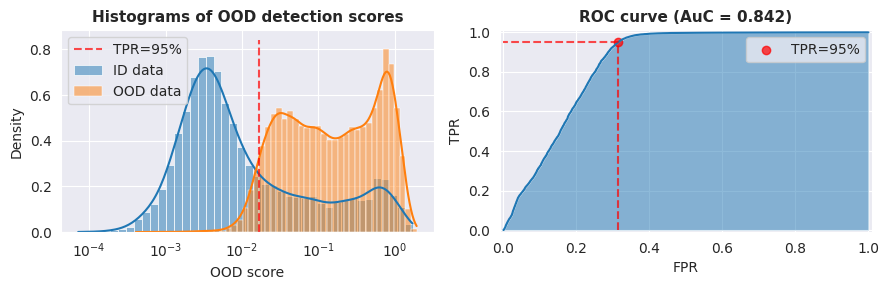

In [46]:
# === Entropy scores ===
entropy.fit(model)
scores_in, _ = entropy.score(ds_in)
scores_out, _ = entropy.score(ds_out)

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=True)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()

# Mahalanobis Method

=== Metrics ===
auroc      0.872268
fpr95tpr   0.289800

=== Plots ===


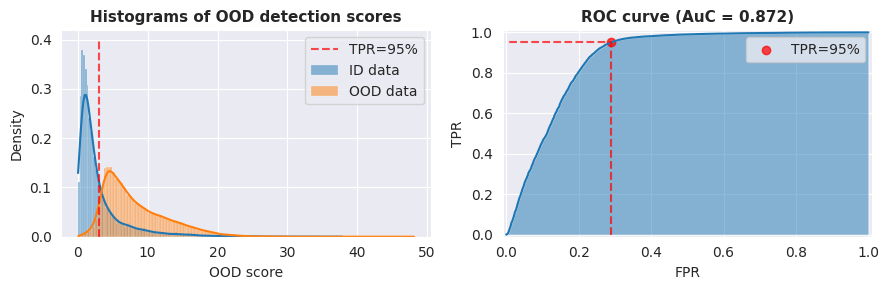

In [47]:
# === mahalanobis scores ===
mahalanobis.fit(model, feature_layers_id=[-1], fit_dataset=ds_train)
scores_in, _ = mahalanobis.score(ds_in)
scores_out, _ = mahalanobis.score(ds_out)

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=False)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()